In [2]:
#Implement a Dataloader read directly from the image folders

import os
import torch
import random

import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [3]:
layer_depth = 32

In [4]:
class LazyLoadDataset(Dataset):
    def __init__(self, samples, transform=None, crop_size=1024):
        self.samples = samples
        self.transform = transform
        self.crop_size = crop_size

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        surface_volume_paths, ink_label_path, mask_path = self.samples[idx]

        surface_volume_paths = surface_volume_paths[18:18+layer_depth]

        # Generate a random crop location
        image_width, image_height = Image.open(surface_volume_paths[0]).size

        x,y = 0,0

        mask_image = Image.open(mask_path)

        while mask_image.getpixel((x, y)) == 0:
            x = random.randint(0, image_width - self.crop_size)
            y = random.randint(0, image_height - self.crop_size)

        surface_volume_images = torch.stack([
            self.apply_crop_and_transform(path, x, y)
            for path in surface_volume_paths
        ])

        ink_label_image = self.apply_crop_and_transform_label(ink_label_path, x, y)

        return surface_volume_images, ink_label_image

    def apply_crop_and_transform(self, image_path, x, y):
        image = Image.open(image_path).crop((x, y, x + self.crop_size, y + self.crop_size))

        if self.transform:
            image = self.transform(image)

        image = image.view(self.crop_size, self.crop_size)
        image = image.float()

        # Normalize pixel values between 0 and 255

        image = 255.0 * (image - image.min()) / (image.max() - image.min())

        #normalize = transforms.Normalize(mean=[image.mean()], std=[image.std()])
        #image = normalize(image)

        return image

    def apply_crop_and_transform_label(self, image_path, x, y):
        image = Image.open(image_path).crop((x, y, x + self.crop_size, y + self.crop_size))
        image = image.resize((int(self.crop_size/4), int(self.crop_size/4)))

        if self.transform:
            image = self.transform(image)

        return image

In [5]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []  # To store tuples of (surface_volume_paths, ink_label_path)

        for class_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                surface_volume_dir = os.path.join(class_dir, "surface_volume")
                ink_label_path = os.path.join(class_dir, "inklabels.png")
                mask_path = os.path.join(class_dir, "mask.png")
                surface_volume_paths = [os.path.join(surface_volume_dir, filename) for filename in os.listdir(surface_volume_dir)]
                self.samples.append((surface_volume_paths, ink_label_path, mask_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        surface_volume_paths, ink_label_path, mask_path = self.samples[idx]

        return surface_volume_paths, ink_label_path, mask_path

In [6]:
# Define the root directory of your dataset
root_dir = '../../Datasets/vesuvius-challenge-ink-detection/train_frag_split/'

In [7]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create the CustomDataset
dataset = CustomDataset(root_dir)
lazy_dataset = LazyLoadDataset(dataset.samples, transform=transform, crop_size=1024)

# Create DataLoader
batch_size = 4
train_loader = DataLoader(lazy_dataset, batch_size=batch_size, shuffle=True)

In [8]:
# Get a batch of data from the DataLoader
batch = next(iter(train_loader))
surface_volume_images, ink_label_images = batch

In [9]:
surface_volume_images.shape

torch.Size([4, 32, 1024, 1024])

In [10]:
ink_label_images.shape

torch.Size([4, 1, 256, 256])

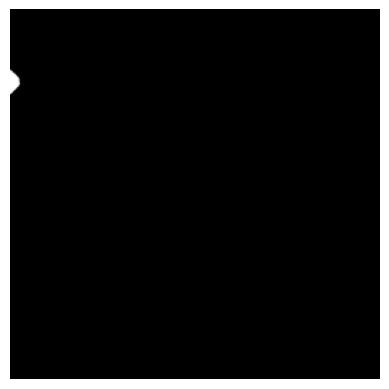

In [11]:
# Display the grayscale image
plt.imshow(ink_label_images[0][0], cmap="gray") #[batch][in_channel][width][hieght]
plt.axis("off")
plt.show()

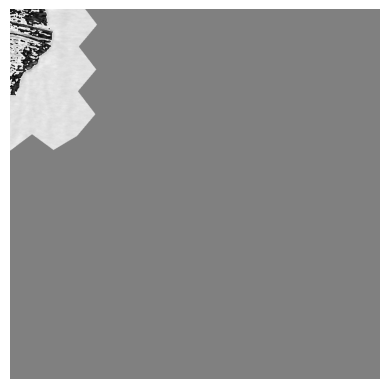

In [12]:
# Display the grayscale image
plt.imshow(surface_volume_images[0][0], cmap="gray") #[batch][layer][in_channel][width][hieght]
plt.axis("off")
plt.show()

In [13]:
#Create a fixed validation list
val_loader = DataLoader(lazy_dataset, batch_size=1, shuffle=True)
val_dataset = []

for i in range(25):
    batch = next(iter(val_loader))
    surface_volumes, ink_label = batch
    val_dataset.append([surface_volumes,ink_label])

In [14]:
val_dataset[0][0]

tensor([[[[202.0623, 196.6693, 193.9844,  ..., 211.7315, 222.6070, 230.1401],
          [209.6537, 206.5020, 207.1245,  ..., 216.3774, 229.4280, 238.5058],
          [211.3813, 210.8210, 216.1362,  ..., 228.0350, 237.7315, 244.2802],
          ...,
          [210.8794, 208.3502, 208.5253,  ..., 188.8560, 197.4280, 209.0272],
          [207.5914, 206.7043, 210.7160,  ..., 184.3541, 193.2257, 208.6615],
          [203.8055, 206.0117, 213.8288,  ..., 189.0739, 201.9455, 219.0039]],

         [[211.6770, 201.5292, 193.8949,  ..., 217.4942, 231.0623, 238.5525],
          [218.4980, 209.9261, 206.1868,  ..., 221.7043, 236.4397, 244.8249],
          [218.8249, 212.1362, 213.4514,  ..., 230.6537, 239.7860, 244.6576],
          ...,
          [223.4008, 221.8288, 222.5253,  ..., 200.4163, 208.7626, 220.5097],
          [219.9222, 219.4475, 223.2685,  ..., 191.5370, 202.3580, 218.3346],
          [214.3735, 215.7626, 223.3074,  ..., 193.9650, 209.4864, 229.2257]],

         [[221.2296, 206.6693,

In [15]:
#UNet Implementation

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as func

from torch.utils.data import DataLoader, Dataset, Subset

In [16]:
torch.cuda.empty_cache()

In [17]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [26]:
#Simple UNet Model without skip connections. Works with 1024x0124 input to output 256x256

class UNetWithoutSkipConnections(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob):
        super(UNetWithoutSkipConnections, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(

            nn.Conv2d(in_channels, 4, kernel_size=3, stride=1, padding=1),#1024x1024x4
            nn.ReLU(),
            nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1), #1024x1024x4
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #512x512x4

            nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1),#512x512x8
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1), #512x512x8
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #256x256x8

            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),#256x256x16
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1), #256x256x16
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #128x128x16

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),#128x128x32
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1), #128x128x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #64x64x32

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),#64x64x64
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), #64x64x64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #32x32x64

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),#32x32x128
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), #32x32x128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #16x16x128

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),#16x16x256
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), #16x16x256
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #8x8x256

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),#8x8x512
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), #8x8x512
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #4x4x512
        )

        # Decoder
        self.decoder = nn.Sequential(

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), #4x4x512
            nn.Upsample(scale_factor=2),#8x8x512
            nn.ReLU(),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1), #8x8x256
            nn.Upsample(scale_factor=2),#16x16x256
            nn.ReLU(),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),#16x16x128
            nn.Upsample(scale_factor=2),#32x32x128
            nn.ReLU(),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),#32x32x64
            nn.Upsample(scale_factor=2), #64x64x64
            nn.ReLU(),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),#64x64x32
            nn.Upsample(scale_factor=2), #128x128x32
            nn.ReLU(),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),#128x128x16
            nn.Upsample(scale_factor=2), #256x256x16
            nn.ReLU(),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(16, out_channels, kernel_size=3, stride=1, padding=1), #256x256x1
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [27]:
#Using pretrained ALPUB UNet to train a model

model = UNetWithoutSkipConnections(in_channels=layer_depth, out_channels=1, dropout_prob=0.1)  # Create an instance of the model

# # Load the saved model weights
# saved_model_path = '../models/papyri_autoencoder_256_upsample_u_net_greyscale_epoch_30_batch_16.pt'
#
# # Load the state dictionary of the saved model
# saved_model_dict = torch.load(saved_model_path).state_dict()
# model_dict = model.state_dict()

In [28]:
# model_dict['decoder.0.weight'] = saved_model_dict['decoder.0.weight']
# model_dict['decoder.0.bias'] = saved_model_dict['decoder.0.bias']
# model_dict['decoder.4.weight'] = saved_model_dict['decoder.4.weight']
# model_dict['decoder.4.bias'] = saved_model_dict['decoder.4.bias']
# model_dict['decoder.8.weight'] = saved_model_dict['decoder.8.weight']
# model_dict['decoder.8.bias'] = saved_model_dict['decoder.8.bias']
# model_dict['decoder.12.weight'] = saved_model_dict['decoder.12.weight']
# model_dict['decoder.12.bias'] = saved_model_dict['decoder.12.bias']
# model_dict['decoder.16.weight'] = saved_model_dict['decoder.16.weight']
# model_dict['decoder.16.bias'] = saved_model_dict['decoder.16.bias']
# model_dict['decoder.20.weight'] = saved_model_dict['decoder.20.weight']
# model_dict['decoder.20.bias'] = saved_model_dict['decoder.20.bias']
# model_dict['decoder.24.weight'] = saved_model_dict['decoder.24.weight']
# model_dict['decoder.24.bias'] = saved_model_dict['decoder.24.bias']

Epoch 0 Processing Batch No: 1
Epoch 0 Processing Batch No: 2
Epoch [1/100], Train Loss: 0.3464, Test Loss: 1.6613
Epoch 1 Processing Batch No: 1
Epoch 1 Processing Batch No: 2
Epoch [2/100], Train Loss: 0.4628, Test Loss: 1.6666
Epoch 2 Processing Batch No: 1
Epoch 2 Processing Batch No: 2
Epoch [3/100], Train Loss: 0.2845, Test Loss: 1.6651
Epoch 3 Processing Batch No: 1
Epoch 3 Processing Batch No: 2
Epoch [4/100], Train Loss: 0.2896, Test Loss: 1.6663
Epoch 4 Processing Batch No: 1
Epoch 4 Processing Batch No: 2
Epoch [5/100], Train Loss: 0.3105, Test Loss: 1.6650
Epoch 5 Processing Batch No: 1
Epoch 5 Processing Batch No: 2
Epoch [6/100], Train Loss: 0.2870, Test Loss: 1.6624
Epoch 6 Processing Batch No: 1
Epoch 6 Processing Batch No: 2
Epoch [7/100], Train Loss: 0.4617, Test Loss: 1.6620
Epoch 7 Processing Batch No: 1
Epoch 7 Processing Batch No: 2
Epoch [8/100], Train Loss: 0.4375, Test Loss: 1.6590
Epoch 8 Processing Batch No: 1
Epoch 8 Processing Batch No: 2
Epoch [9/100], Tra

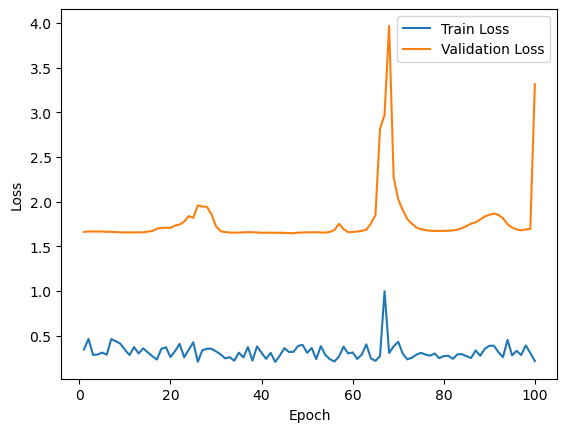

In [36]:
model = model.to(device)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
batch_size = 4

best_test_loss = float('inf')
best_model_state = None

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_loss = 0.0
    test_loss = 0.0

    # Training
    model.train()

    batch_no = 1

    for batch in train_loader:

        print('Epoch',epoch,'Processing Batch No:', batch_no)

        images, labels = batch

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        reconstructions = model(images)
        loss = criterion(reconstructions, labels.float())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

        batch_no = batch_no + 1

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluation
    model.eval()
    with torch.no_grad():
        for batch in val_dataset:
            images, labels = batch

            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            reconstructions = model(images)
            loss = criterion(reconstructions, labels.float())

            test_loss += loss.item() * images.size(0)

        test_loss /= len(val_loader.dataset)
        test_losses.append(test_loss)

        # Check if current model has the lowest test loss so far
        # if test_loss < best_test_loss:
        #     best_test_loss = test_loss
        #     best_model_state = model.state_dict().copy()



    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    if epoch % 50 == 0:
        torch.save(model, '../models/ink_detection_pretrained_papyri_1024_256_upsample_u_net_middle_layer_'+str(layer_depth)+'epoch_'+str(num_epochs)+'_batch_'+str(batch_size)+'.pt')

# Plotting train and test loss
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
model = torch.load('../models/ink_detection_pretrained_papyri_1024_256_upsample_u_net_middle_layer_32epoch_100_batch_4.pt')

model.eval()  # Set the model to evaluation mode

results_test = []

with torch.no_grad():
    for batch in train_loader:
        # Move the batch to the GPU if available
        image, label = batch

        # Perform inference
        outputs = model(image.to(device))
        results_test.append(label)
        results_test.append(outputs)

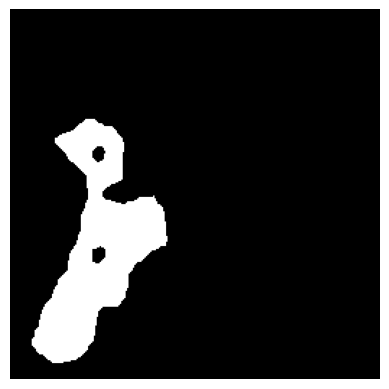

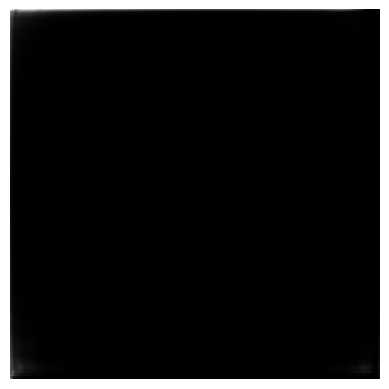

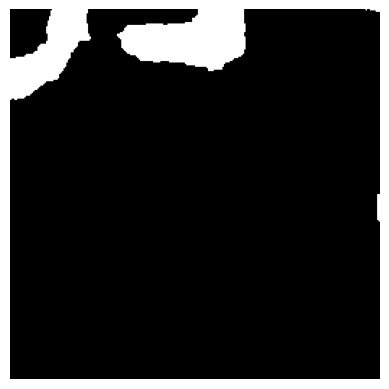

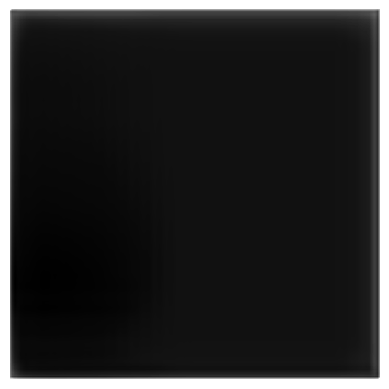

In [38]:
outputs_np = []
for result in results_test:
    # Convert the PyTorch tensor to a NumPy array
    outputs_np.append(result.cpu().numpy())

# Iterate over the outputs
for i in range(len(outputs_np)):
    output = outputs_np[i][0][0]

    # Display the output as an image
    plt.imshow(output, cmap='gray')  # Assuming grayscale images
    plt.axis('off')
    plt.show()